# Import packages

In [215]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
import numpy as np

from typing import Dict, List, Tuple, Sequence


# Import raw weather data from Open-Meteo API

In [216]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2020-10-15",
	"end_date": "2025-10-15",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "rain", "wind_speed_10m", "cloud_cover", "pressure_msl"],
	"timezone": "Europe/Berlin",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["rain"] = hourly_rain
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["pressure_msl"] = hourly_pressure_msl

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 52.5483283996582°N 13.407821655273438°E
Elevation: 38.0 m asl
Timezone: b'Europe/Berlin'b'GMT+1'
Timezone difference to GMT+0: 3600s

Hourly data
                            date  temperature_2m  relative_humidity_2m  \
0     2020-10-14 23:00:00+00:00       10.308500             93.205261   
1     2020-10-15 00:00:00+00:00       10.608500             92.596809   
2     2020-10-15 01:00:00+00:00       10.408501             93.524292   
3     2020-10-15 02:00:00+00:00       10.358500             93.207855   
4     2020-10-15 03:00:00+00:00       10.458500             90.736458   
...                         ...             ...                   ...   
43843 2025-10-15 18:00:00+00:00       11.758500             86.669823   
43844 2025-10-15 19:00:00+00:00       11.608500             87.826500   
43845 2025-10-15 20:00:00+00:00       11.558500             87.234390   
43846 2025-10-15 21:00:00+00:00       11.508500             87.229691   
43847 2025-10-15 22:00:00+00:00      

In [217]:
#hourly_dataframe.to_csv("./raw_data/weather_data_20221015-20251015.csv")

# Data exploration and additional variables

In [218]:
hourly_dataframe.shape

(43848, 9)

In [219]:
hourly_dataframe.dtypes

date                    datetime64[ns, UTC]
temperature_2m                      float32
relative_humidity_2m                float32
dew_point_2m                        float32
apparent_temperature                float32
rain                                float32
wind_speed_10m                      float32
cloud_cover                         float32
pressure_msl                        float32
dtype: object

In [220]:
#Check basic statistics
hourly_dataframe.describe()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,wind_speed_10m,cloud_cover,pressure_msl
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000
mean,10.969949,75.118752,6.133422,8.407594,0.068352,13.076891,67.152321,1015.805786
std,8.132426,17.685669,6.264606,9.509990,0.339710,6.379364,39.591610,9.596687
min,-14.891500,11.133884,-16.441500,-20.370838,0.000000,0.000000,0.000000,978.599976
25%,4.658500,63.571275,1.658500,0.769679,0.000000,8.311245,27.000000,1009.900024
50%,10.608500,79.578133,6.258500,7.782395,0.000000,12.074766,94.000000,1016.200012
75%,17.008501,89.670626,10.958500,15.833138,0.000000,16.781561,100.000000,1022.099976
max,37.708500,100.000000,21.358500,36.522781,13.700000,49.743870,100.000000,1046.300049


In [221]:
#check null values
hourly_dataframe.isnull().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
dew_point_2m            0
apparent_temperature    0
rain                    0
wind_speed_10m          0
cloud_cover             0
pressure_msl            0
dtype: int64

In [222]:
hourly_dataframe.set_index('date',inplace = True, drop = True)

In [223]:
hourly_dataframe.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,wind_speed_10m,cloud_cover,pressure_msl
date,,,,,,,,
2020-10-14 23:00:00+00:00,10.308500,93.205261,9.258500,7.490734,0.3,18.014393,100.0,1010.400024
2020-10-15 00:00:00+00:00,10.608500,92.596809,9.458500,8.003060,0.1,16.935310,99.0,1011.000000
2020-10-15 01:00:00+00:00,10.408501,93.524292,9.408501,7.789260,0.1,16.935310,100.0,1011.200012
2020-10-15 02:00:00+00:00,10.358500,93.207855,9.308500,7.229817,0.1,20.240196,100.0,1011.299988
2020-10-15 03:00:00+00:00,10.458500,90.736458,9.008500,7.118605,0.0,21.129885,100.0,1011.599976


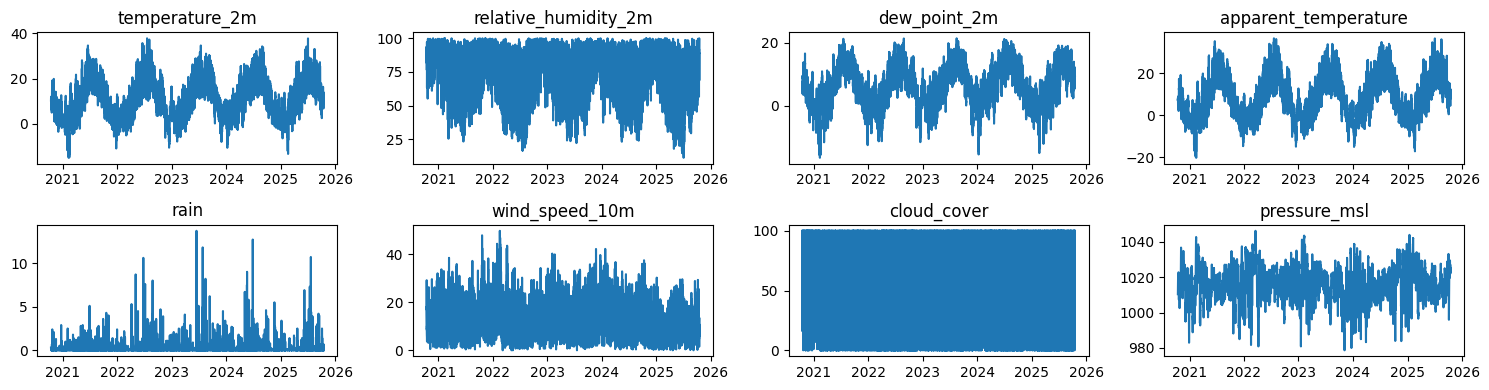

In [224]:
#Plot every variable to check if we have obvious outliers
fig, ax = plt.subplots(2,4, figsize = (15,4))
axes = ax.flatten()

for i, a in enumerate(axes):
    a.plot(hourly_dataframe.iloc[:,i])
    a.set_title(f"{hourly_dataframe.columns[i]}")

plt.tight_layout()
plt.show()

In [225]:
# Check if we have missing rows

# nb of rows expected
expected_rows= int((hourly_dataframe.index.max(
) - hourly_dataframe.index.min()).total_seconds() / 3600) +1
print(f'Expected number of rows : {expected_rows}')

# Current rows
actual_rows = len(hourly_dataframe)
print(f'Actual number of rows : {actual_rows}')

#Missing rows
missing_rows = expected_rows - actual_rows
print(f'Missing rows : {missing_rows}')


Expected number of rows : 43848
Actual number of rows : 43848
Missing rows : 0


In [ ]:
def fill_missing_timestamps(df:pd.DataFrame)->pd.DataFrame:
    '''
    Check if some rows are missing; fill them with linear interpolation and return
    the full dataframe.
    Datetime data have to be the index.
    '''
    full_index = pd.date_range(start=df.index.min(),
                           end=df.index.max(),
                           freq='h')

    missing_timestamps = full_index.difference(df.index)

    df = df.reindex(full_index)
    df= df.interpolate(method='linear')
    df.index.name = 'datetime'
    if len(missing_timestamps) != 0:
        print(f"{len(missing_timestamps)} missing timestamp(s) interpolated")
    return df


In [242]:
hourly_dataframe = fill_missing_timestamps(hourly_dataframe)

In [12]:
#Retrieve data as a variable
hourly_dataframe = hourly_dataframe.reset_index().rename(columns={'index': 'date'})

In [13]:
#Create cyclical variables
#NB : if we finally decide to take more years in the dataset, then we should compute cyclical variables
#for the year
hourly_dataframe['Day_of_Year_sin'] = np.sin(2 * np.pi * hourly_dataframe['date'].dt.dayofyear / 365)
hourly_dataframe['Day_of_Year_cos'] = np.cos(2 * np.pi * hourly_dataframe['date'].dt.dayofyear / 365)
hourly_dataframe['Day_of_Week_sin'] = np.sin(2 * np.pi * hourly_dataframe['date'].dt.weekday / 7)
hourly_dataframe['Day_of_Week_cos'] = np.cos(2 * np.pi * hourly_dataframe['date'].dt.weekday / 7)
hourly_dataframe['Hour_sin'] = np.sin(2 * np.pi * hourly_dataframe['date'].dt.hour / 24)
hourly_dataframe['Hour_cos'] = np.cos(2 * np.pi * hourly_dataframe['date'].dt.hour / 24)

In [14]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,wind_speed_10m,cloud_cover,pressure_msl,Day_of_Year_sin,Day_of_Year_cos,Day_of_Week_sin,Day_of_Week_cos,Hour_sin,Hour_cos
0,2020-10-14 23:00:00+00:00,10.308500,93.205261,9.258500,7.490734,0.3,18.014393,100.0,1010.400024,-0.970064,0.242850,0.974928,-0.222521,-0.258819,0.965926
1,2020-10-15 00:00:00+00:00,10.608500,92.596809,9.458500,8.003060,0.1,16.935310,99.0,1011.000000,-0.965740,0.259512,0.433884,-0.900969,0.000000,1.000000
2,2020-10-15 01:00:00+00:00,10.408501,93.524292,9.408501,7.789260,0.1,16.935310,100.0,1011.200012,-0.965740,0.259512,0.433884,-0.900969,0.258819,0.965926
3,2020-10-15 02:00:00+00:00,10.358500,93.207855,9.308500,7.229817,0.1,20.240196,100.0,1011.299988,-0.965740,0.259512,0.433884,-0.900969,0.500000,0.866025
4,2020-10-15 03:00:00+00:00,10.458500,90.736458,9.008500,7.118605,0.0,21.129885,100.0,1011.599976,-0.965740,0.259512,0.433884,-0.900969,0.707107,0.707107


In [15]:
#We don't need the date column anymore, so let's drop it
hourly_dataframe.drop(columns = ['date'], inplace = True)

In [16]:
hourly_dataframe

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,rain,wind_speed_10m,cloud_cover,pressure_msl,Day_of_Year_sin,Day_of_Year_cos,Day_of_Week_sin,Day_of_Week_cos,Hour_sin,Hour_cos
0,10.308500,93.205261,9.258500,7.490734,0.3,18.014393,100.0,1010.400024,-0.970064,0.242850,0.974928,-0.222521,-0.258819,9.659258e-01
1,10.608500,92.596809,9.458500,8.003060,0.1,16.935310,99.0,1011.000000,-0.965740,0.259512,0.433884,-0.900969,0.000000,1.000000e+00
2,10.408501,93.524292,9.408501,7.789260,0.1,16.935310,100.0,1011.200012,-0.965740,0.259512,0.433884,-0.900969,0.258819,9.659258e-01
3,10.358500,93.207855,9.308500,7.229817,0.1,20.240196,100.0,1011.299988,-0.965740,0.259512,0.433884,-0.900969,0.500000,8.660254e-01
4,10.458500,90.736458,9.008500,7.118605,0.0,21.129885,100.0,1011.599976,-0.965740,0.259512,0.433884,-0.900969,0.707107,7.071068e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,11.758500,86.669823,9.608500,10.796570,0.0,5.950899,100.0,1024.099976,-0.970064,0.242850,0.974928,-0.222521,-1.000000,-1.836970e-16
43844,11.608500,87.826500,9.658501,10.686743,0.0,5.771239,100.0,1023.900024,-0.970064,0.242850,0.974928,-0.222521,-0.965926,2.588190e-01
43845,11.558500,87.234390,9.508500,10.426756,0.0,6.924738,100.0,1023.599976,-0.970064,0.242850,0.974928,-0.222521,-0.866025,5.000000e-01
43846,11.508500,87.229691,9.458500,10.183384,0.0,8.155807,100.0,1023.500000,-0.970064,0.242850,0.974928,-0.222521,-0.707107,7.071068e-01


👆 In the preprocessed dataset, we have :
- $26$k rows  (~ 3 years of weather data)
- $14$ features composed of:
    - $4$ <font color=green>**target**</font> (we will use the past values of the temperature, wind, rain, humidity as a feature)
    - $10$ <font color=orange>**past covariates**</font> (= features which past values are known)
    - $0$ <font color=blue>**future covariates**</font> (= features which future values are known, e.g. public holidays)

In [17]:
hourly_dataframe.shape

(43848, 14)

👨🏻‍🏫 This weather dataset is a DataFrame (dimension = 2) which is a single Time Series from the beginning of October 2022 to October 2025 with records every hour.

* `df.shape = (n_timesteps, n_features) = (26328, 14)`

🎯 The goal is to predict the temperature, wind, rain, humidity for the next 12 hours using the past values.

In [18]:
# Let's define the global variables of our dataset
TARGET = ['temperature_2m','relative_humidity_2m', 'rain','wind_speed_10m']
N_TARGETS = 4
N_FEATURES = 14


In [211]:
TARGET_INDEX = [hourly_dataframe.columns.get_loc(t) for t in TARGET]

# Data preparation

## Create folds for cross-validation

Each of them with shape `(FOLD_LENGTH, n_features)` 

Let's define some global variables that we will use for our tests everywhere in this notebook:

In [19]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 24*365 * 3 # every hour
                        # three years

# --------------------------------------------------- #
# Let's consider FOLDS starting every trimester       #
# --------------------------------------------------- #

FOLD_STRIDE = 24*91 # every hour
                   # 1 quarter = 91 days

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.66


In [20]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    result = []
    i = 0
    while(fold_length   <= (df.shape[0] - i + 1)):
        tmp_df = df.iloc[i:(i+fold_length), :]
        result.append(tmp_df)
        i = i + fold_stride
    return result


In [21]:
folds = get_folds(hourly_dataframe, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')


The function generated 9 folds.
Each fold has a shape equal to (26280, 14).


## Temporal Train/Test split

In [136]:
INPUT_DAYS = 3 #number of days for the input_length ; 3 days seems okay since we want to predict the next 12 hours
INPUT_LENGTH = 24 * INPUT_DAYS # records every hour
INPUT_LENGTH = 12 # records every hour
INPUT_LENGTH = 24*14
INPUT_LENGTH = 24

In [137]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """

    fold_train = fold.iloc[0:round(train_test_ratio * len(fold)),:]
    fold_test = fold.iloc[round((train_test_ratio * len(fold)) - input_length):,:]

    return (fold_train, fold_test)


Let's test the function on one fold

In [138]:
fold = folds[0]
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [139]:
assert fold_train.shape[0] == round(TRAIN_TEST_RATIO * fold.shape[0])

## Create (X, y) sequences

In [140]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/24)} days = {int(INPUT_LENGTH/24/7)} weeks')


N_FEATURES = 14
INPUT_LENGTH = 24 timesteps = 1 days = 0 weeks


☝️ `X` is the **input** of our model. 
- It contains $14$ features: the past values of the <font color=green>**target**</font> + $10$ <font color=orange>**past-covariates**</font>
- Each sequence has a length equal to $72$ timesteps (=$3$ days)

In [141]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's predict 12 values ahead of us
# OUTPUT_LENGTH = 12
OUTPUT_LENGTH = 24
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 4
OUTPUT_LENGTH = 24


☝️ `y` is the <font color=green>**target**</font> that we want to predic:t
- It is the value at the 12 next timesteps (= 12 next hours)

Let's build sequences by scanning folds chronologically and create all the possible pairs $(X_i, y_i)$, based on : 
  
  - an `input_length` (let's still use `INPUT_LENGTH = 24 * 3`, i.e. two weeks) 
  - and a `sequence_stride`

👉 Let's scan the fold with a temporal stride of 1 hours (the minimum one):

In [142]:
SEQUENCE_STRIDE = 1  #We need to brainstorm about it   i had 3 before

In [143]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int,
    sequence_stride: int) -> Tuple[np.array]:
    """slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence

    Args:
        fold (pd.DataFrame): One single fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        sequence_stride (int): How many timesteps to take before taking the next X_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][TARGET]
        X.append(X_i)
        y.append(y_i)

    return (np.array(X), np.array(y))


🧑🏻‍🎓 Some clarifications about scanning a fold sequentially :

In [144]:
print("FOLD_LENGTH")
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/24)} days") # 24 records per day, every 1 hour
print(f"= {int(FOLD_LENGTH/24/7)} weeks")

FOLD_LENGTH
= 26280 timesteps
= 1095 days
= 156 weeks


In [145]:
#Build the X_train,y_train, X_test, y_test for one fold

X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(17297, 24, 14)
(17297, 24, 4)


In [156]:
print(X_test.shape)
print(y_test.shape)

(8911, 24, 14)
(8911, 24, 4)


In [146]:
N_TRAIN = X_train.shape[0]
N_TEST = X_test.shape[0]

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

def init_baseline():
    forecast_horizon= OUTPUT_LENGTH
    target_indices = TARGET_INDEX
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: tf.tile(
        tf.expand_dims(tf.gather(x[:, -1, :], target_indices, axis=1), axis=1),
        [1, forecast_horizon, 1]
    )))
    model.compile(loss='mse', optimizer=optimizers.Adam(0.02), metrics=['mae'])
    return model


baseline_model = init_baseline()

y_pred_baseline = baseline_model.predict(X_test)
print("y_pred_baseline shape:", y_pred_baseline.shape)

loss, mae = baseline_model.evaluate(X_test, y_test)
print(f"Baseline MSE: {loss:.4f}, MAE: {mae:.4f}")


279/279 [==============================] - 0s 1ms/step
y_pred_baseline shape: (8911, 24, 4)
279/279 [==============================] - 1s 2ms/step - loss: 93.6370 - mae: 5.2988
Baseline MSE: 93.6370, MAE: 5.2988


# Modelling

**The MAE as a metrics to monitor the temperature prediction**

## Definition of the model and evaluation on a single fold

In [33]:
from tensorflow import keras

2025-10-29 14:39:30.693061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 14:39:32.918650: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 14:39:32.999891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-10-29 14:39:32.999930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [147]:
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, Input

def init_model(X_train, y_train):

    # 0 - Normalization
    # ======================
    normalizer = Normalization()
    normalizer.adapt(X_train)

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()
    #model.add(Input(shape=X_train[0].shape)) --> no need because Normalization apprend l'input
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = True,
                          kernel_regularizer=L1L2(l1=0.01, l2=0.01),
                          ))

    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[2]
    model.add(layers.TimeDistributed(layers.Dense(output_length, activation='linear')))
    #model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [148]:
X_train.shape[1:]

(24, 14)

In [76]:
#Other version

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, metrics,Sequential
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization, Input,Bidirectional,LSTM

def init_model(X_train, y_train):

    model = Sequential()
    normalizer = Normalization()
    normalizer.adapt(X_train)
    model.add(layers.Bidirectional(LSTM(256, return_sequences=True), input_shape=X_train.shape[1:]))
    # model.add(LayerNormalization())
    # model.add(Dropout(0.2))
    model.add(layers.Bidirectional(LSTM(128, return_sequences=True)))
    # model.add(LayerNormalization())
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    # model.add(Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    output_length = y_train.shape[2]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [77]:
y_train.shape

(5774, 12, 4)

In [149]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_27 (Normaliza  (None, None, 14)         29        
 tion)                                                           
                                                                 
 lstm_33 (LSTM)              (None, None, 64)          20224     
                                                                 
 time_distributed_20 (TimeDi  (None, None, 4)          260       
 stributed)                                                      
                                                                 
Total params: 20,513
Trainable params: 20,484
Non-trainable params: 29
_________________________________________________________________


In [150]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax


In [151]:
from keras.callbacks import EarlyStopping


def fit_model(model):
    es = EarlyStopping(patience = 3,monitor= 'val_loss', restore_best_weights = True, mode = 'min')

    history = model.fit(X_train,
                        y_train,
                        epochs = 50,
                        batch_size = 32,
                        validation_split= 0.3,
                        callbacks = [es],
                        verbose = 0
    )

    return model,history

In [152]:
# 1 - Initializing the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_28 (Normaliza  (None, None, 14)         29        
 tion)                                                           
                                                                 
 lstm_34 (LSTM)              (None, None, 64)          20224     
                                                                 
 time_distributed_21 (TimeDi  (None, None, 4)          260       
 stributed)                                                      
                                                                 
Total params: 20,513
Trainable params: 20,484
Non-trainable params: 29
_________________________________________________________________


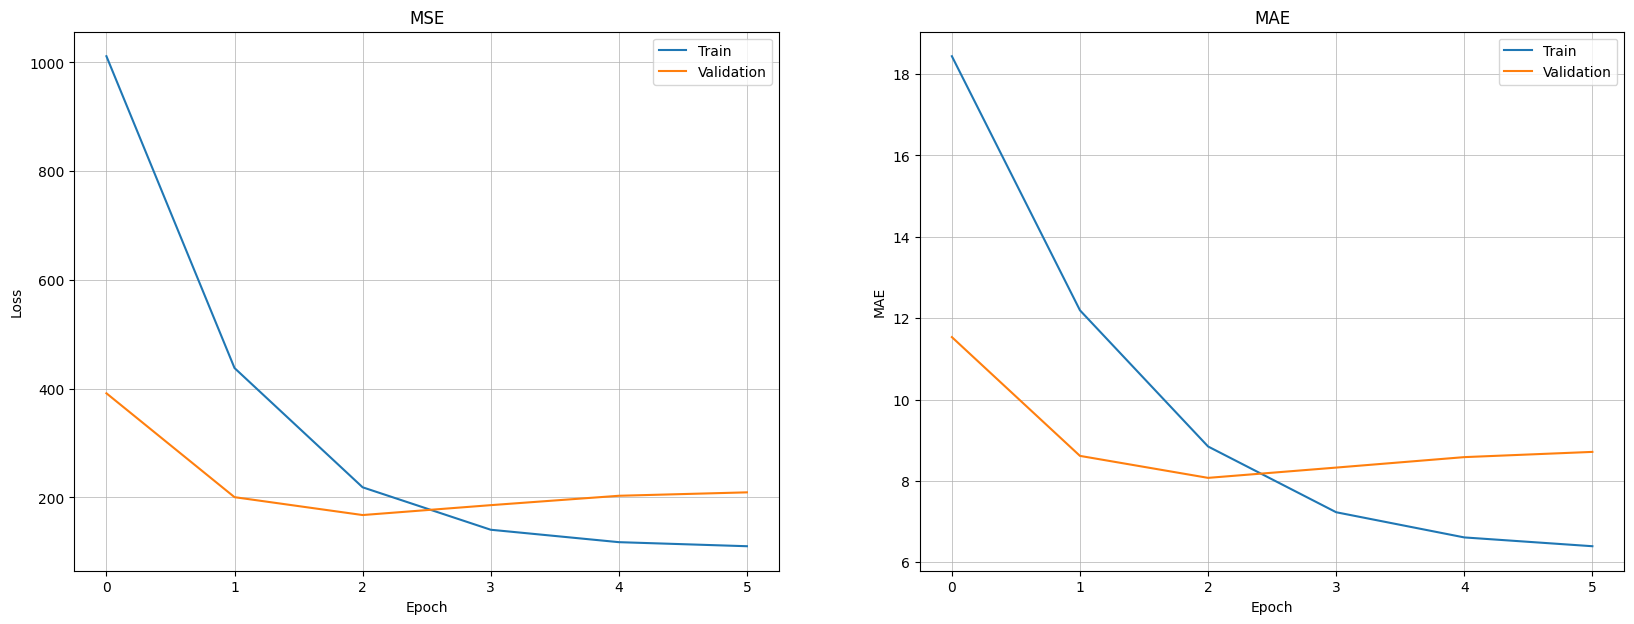

In [153]:
plot_history(history);

In [154]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")


279/279 [==============================] - 7s 23ms/step - loss: 165.6959 - mae: 7.9419
The LSTM MAE on the test set is equal to 7.94 Celsius degrees


In [155]:
y_pred = model.predict(X_test)
y_pred.shape

279/279 [==============================] - 9s 22ms/step


(8911, 24, 4)

In [160]:
y_pred[0,:,0]

array([2.0690289, 6.120437 , 8.270967 , 8.509909 , 8.542845 , 8.54734  ,
       8.547954 , 8.54804  , 8.548051 , 8.548048 , 8.548048 , 8.548046 ,
       8.548046 , 8.548045 , 8.548046 , 8.548041 , 8.548032 , 8.5480175,
       8.548009 , 8.547989 , 8.547977 , 8.547974 , 8.547977 , 8.547991 ],
      dtype=float32)

In [161]:
y_test[0,:,0]

array([14.0085   , 11.2085   , 10.5085   ,  9.7085   ,  9.7585   ,
        9.6085005,  9.158501 ,  8.6085005,  8.5585   ,  8.9585   ,
        9.6085005,  9.658501 ,  9.1085005,  8.3085   ,  8.908501 ,
       11.2085   , 13.2585   , 14.5085   , 15.408501 , 15.8585005,
       13.8085   , 14.0585   , 14.158501 , 12.658501 ], dtype=float32)

## Cross-validation

In [41]:
# Reminders of the global variables in this notebook --> TO DELETE

print(f'N_FEATURES = {N_FEATURES}')
print(f'N_TARGETS = {N_TARGETS}')
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'N_TRAIN = {N_TRAIN}')
print(f'N_TEST = {N_TEST}')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 14
N_TARGETS = 4

FOLD_LENGTH = 26280
FOLD_STRIDE = 2184
TRAIN_TEST_RATIO = 0.66

N_TRAIN = 5754
N_TEST = 2975
INPUT_LENGTH = 72
OUTPUT_LENGTH = 12


In [105]:
from keras.callbacks import EarlyStopping

def cross_validate_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(hourly_dataframe, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

        # 2 - Modelling
        # =========================================

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2,
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

    return list_of_mae_recurrent_model


In [107]:
mae_lstms = cross_validate_lstm()

MAE LSTM fold n°0 = 8.25
MAE LSTM fold n°1 = 6.92
MAE LSTM fold n°2 = 4.96
MAE LSTM fold n°3 = 4.39
MAE LSTM fold n°4 = 4.4
MAE LSTM fold n°5 = 4.75
MAE LSTM fold n°6 = 7.35
MAE LSTM fold n°7 = 4.31
MAE LSTM fold n°8 = 7.71
